# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import json

from itertools import islice

from scipy.sparse import coo_matrix  # LightFM fit method requires coo matrix format as input.
from scipy.sparse import csr_matrix

from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightfm.data import Dataset

/Users/konstantinorlovskiy/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


# Preprocessing
## Data Import and Cleaning - Events

In [2]:
# Importing Events data and sorting by timestamp column which corresponds the historical order of events.

df_events = pd.read_csv("events.csv")
df_events = df_events.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [3]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,addtocart,297662,NaN
1,1430622011289,829044,view,60987,NaN
2,1430622013048,652699,view,252860,NaN
3,1430622024154,1125936,view,33661,NaN
4,1430622026228,693516,view,297662,NaN


In [4]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            object
itemid           int64
transactionid    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [5]:
qty_all_users_original = len(df_events.visitorid.unique())
qty_all_items_original = len(df_events.itemid.unique())
qty_all_interactions_original = len(df_events)
sparsity_original = qty_all_interactions_original/(qty_all_users_original*qty_all_items_original)

print('Original number of users:', qty_all_users_original)
print('Original number of items:', qty_all_items_original)
print('Original number of interactions:', qty_all_interactions_original)
print('Original sparsity:', round(sparsity_original*100,6), '%')

Original number of users: 1407580
Original number of items: 235061
Original number of interactions: 2756101
Original sparsity: 0.000833 %


In [6]:
# Events types “view”, “addtocart”, “transaction” are the implicit customer feedback.
# They cannot be considered as rating (explicit feedback).
# This information is implicit feedback and lightFM library was designed to deal with it.
# Transform events from categorical to numerical format for further processing.

weight_view = 1
weight_addtocart = 2
weight_transaction = 3

df_events.event.replace(to_replace=dict(
    view=weight_view, addtocart=weight_addtocart, transaction=weight_transaction), inplace=True)

In [7]:
# Now the events replaced with corresponding weights.
df_events.event.unique()

array([2, 1, 3])

In [8]:
df_events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1430622004384,693516,2,297662,NaN
1,1430622011289,829044,1,60987,NaN
2,1430622013048,652699,1,252860,NaN
3,1430622024154,1125936,1,33661,NaN
4,1430622026228,693516,1,297662,NaN


In [9]:
# The user may have interacted with item multiple times which is now stored in dataframe.
# For the purpose of recommendation we're interested in the highest level of user interest to the item.
# Therefore, the data can be further cleaned.

df_events = df_events.sort_values('event').drop_duplicates(
    subset=['visitorid', 'itemid'], 
    keep='last').sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

In [10]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145179 entries, 0 to 2145178
Data columns (total 5 columns):
timestamp        int64
visitorid        int64
event            int64
itemid           int64
transactionid    float64
dtypes: float64(1), int64(4)
memory usage: 81.8 MB


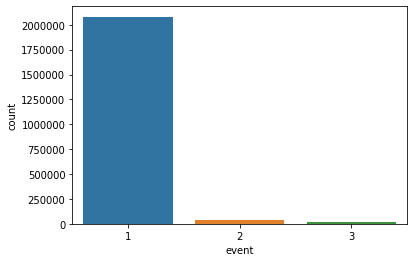

In [11]:
# View on the ratio between different types of events.
sns.countplot(x='event', data=df_events)

In [12]:
# Count activities by user.
users_activity = df_events.groupby('visitorid').visitorid.count().to_frame(name='activity_count')
users_activity.head()

,activity_count
visitorid,
0,3
1,1
2,4
3,1
4,1


In [13]:
# View on the most active users
users_activity.loc[users_activity['activity_count'] > 1000].sort_values(
    by='activity_count', ascending=False).head(10)

,activity_count
visitorid,
1150086,3814
530559,2209
892013,1738
895999,1641
152963,1622
371606,1399
163561,1314
79627,1257
286616,1230


In [14]:
df_events.loc[df_events['visitorid'] == 1150086].head(10)

,timestamp,visitorid,event,itemid,transactionid
628771,1434034517389,1150086,1,133542,NaN
629008,1434035735608,1150086,1,167873,NaN
629054,1434036006651,1150086,1,231726,NaN
629104,1434036288806,1150086,1,427777,NaN
629170,1434036525614,1150086,3,398115,7510.0
629208,1434036727711,1150086,1,203425,NaN
629246,1434036891672,1150086,1,458489,NaN
629369,1434037348016,1150086,3,375955,6495.0
629421,1434037596453,1150086,3,357133,5235.0
629625,1434038553908,1150086,2,368244,NaN


In [15]:
# Check the hypothesys: the more interactions the user had, the more likely addtocart/purchase was made.
# Based on this hypothesys the users can be divided into two groups.

# First group is 'low activity' users - this group is mostly browsing and not making many purchases.
# The ratio of addtocart/purchase is low so it is harder to understand what they really like.
# Therefore, all types of interactions (view/addtocart/purchase) can be counted as positive.
# This will lead at least to improvement of customer experience and users are more likely to find the needed item.
# For the purposes of this project 'low activity' group will be left aside as the goal is basket value, not UX.

# Second group is 'high activity' users - this group has higher ratio of purchases.
# Therefore, addtocart/purchase can be considered as positive interactions and predictions be made on them.
# View interactions are not considered since the user has not proceeded so this means there's low interest.
# This will allow to get rid of noise.
# For the purposes of this project 'high activity' group will be used.

# Overall, using this split resolves several issues:
# 1. The low activity users represent the noise which will affect the model performance.
# 2. The size of dataframe used for the further steps will be significantly smaller saving computational cost.

In [16]:
# Develop the function to see how the number of interactions impacts conversion.

def activity_counter(data, max_interaction_threshold):
    
    df_events = data
    users_activity = df_events.groupby('visitorid').visitorid.count().to_frame(name='activity_count')
    count_aggregated = pd.DataFrame(columns = ['interaction_threshold', 
                                               'view', 'addtocart', 'purchase', 
                                               'conversion', 
                                               'total_interactions'])
    
    for interaction_threshold in range(max_interaction_threshold):
        users_activity_low = users_activity.loc[users_activity['activity_count'] <= interaction_threshold]
        users_to_remove = users_activity_low.index.tolist()
        df_events = df_events[~df_events.visitorid.isin(users_to_remove)].reset_index(drop=True)
        
        count = df_events['event'].value_counts()
        count_aggregated = count_aggregated.append({
            'interaction_threshold': int(interaction_threshold), 
            'view': int(count[weight_view]), 
            'addtocart': int(count[weight_addtocart]), 
            'purchase': int(count[weight_transaction]), 
            'conversion': (count[weight_addtocart] + count[weight_transaction])/len(df_events),
            'total_interactions': len(df_events)
        }, 
            ignore_index=True)
        
    return(count_aggregated)

In [17]:
# Run fuction.
activities = activity_counter(df_events, 100)
activities.head(10)

,interaction_threshold,view,addtocart,purchase,conversion,total_interactions
0,0.0,2080929.0,42980.0,21270.0,0.029951,2145179.0
1,1.0,978187.0,30775.0,16717.0,0.046303,1025679.0
2,2.0,645875.0,24367.0,14335.0,0.056534,684577.0
3,3.0,488582.0,20490.0,12800.0,0.063790,521872.0
4,4.0,397669.0,17758.0,11809.0,0.069205,427236.0
5,5.0,337186.0,15840.0,10960.0,0.073629,363986.0
6,6.0,294957.0,14365.0,10264.0,0.077065,319586.0
7,7.0,264109.0,13083.0,9809.0,0.079763,287001.0
8,8.0,239898.0,12078.0,9441.0,0.082317,261417.0
9,9.0,220596.0,11162.0,9085.0,0.084067,240843.0


Text(0.5, 0, 'Interactions per user')

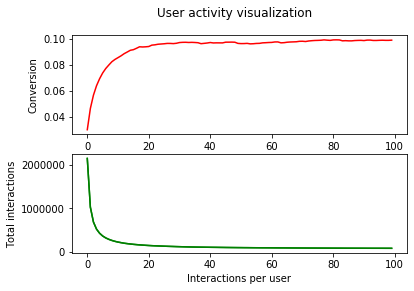

In [18]:
figure, (axis_1, axis_2) = plt.subplots(2)
figure.suptitle('User activity visualization')

axis_1.plot(activities['interaction_threshold'], activities['conversion'], 'r')
axis_1.set_ylabel('Conversion')

axis_2.plot(activities['interaction_threshold'], activities['total_interactions'], 'g')
axis_2.plot(activities['interaction_threshold'], activities['total_interactions'], 'g')
axis_2.set_ylabel('Total interactions')
axis_2.set_xlabel('Interactions per user')

In [19]:
# The plot above shows that positive ratio improvement slows down significantly at 20 interactions threshold.
# Plateau is at conversion rate ~0.1 (10%) which is good in comparison to eCommerce industry standard 3%.
# It makes sense since the part of less active users was removed.

# Hypothesis is now proved. 

# Split point to divide users into two groups:
# 'low activity' users with 20 and less interactions.
# 'high activity' users with more than 20 interactions.

In [20]:
# Set interactions threshold and remove 'low activity' users.

interaction_threshold = 20

# Create list of users that need to be removed from events data.
users_activity_low = users_activity.loc[users_activity['activity_count'] <= interaction_threshold]
users_to_remove = users_activity_low.index.tolist()

# Remove low activity users from dataframe.
df_events = df_events[~df_events.visitorid.isin(users_to_remove)].reset_index(drop=True)

In [21]:
# Select which types of interaction to be used: weight_view / weight_addtocart / weight_transaction.
# View interactions are not considered since the user has not proceeded so this means there's low interest.

df_events = df_events.loc[df_events['event'].isin(
    [weight_addtocart, 
     weight_transaction])].reset_index(drop=True)

df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13675 entries, 0 to 13674
Data columns (total 5 columns):
timestamp        13675 non-null int64
visitorid        13675 non-null int64
event            13675 non-null int64
itemid           13675 non-null int64
transactionid    7271 non-null float64
dtypes: float64(1), int64(4)
memory usage: 534.3 KB


In [22]:
# Final view on users and items participating in model training and testing. 

qty_all_users = len(df_events['visitorid'].unique())
print('Original number of users:', qty_all_users_original)
print('Cleaned dataset number of users: ', qty_all_users)
print('Cleaned portion:', round(100*qty_all_users/qty_all_users_original,2), '%')
print()

qty_all_items = len(df_events['itemid'].unique())
print('Original number of items:', qty_all_items_original)
print('Cleaned dataset number of items: ', qty_all_items)
print('Cleaned portion:', round(100*qty_all_items/qty_all_items_original,2), '%')
print()

qty_all_interactions = len(df_events)
print('Original number of interactions:', qty_all_interactions_original)
print('Cleaned dataset number of interactions: ', qty_all_interactions)
print('Cleaned portion:', round(100*qty_all_interactions/qty_all_interactions_original,2), '%')
print()

sparsity = qty_all_interactions/(qty_all_users*qty_all_items)
print('Original sparsity: ', round(sparsity_original*100,6), '%')
print('Cleaned sparsity: ', round(100*sparsity,6), '%')

Original number of users: 1407580
Cleaned dataset number of users:  1015
Cleaned portion: 0.07 %

Original number of items: 235061
Cleaned dataset number of items:  9490
Cleaned portion: 4.04 %

Original number of interactions: 2756101
Cleaned dataset number of interactions:  13675
Cleaned portion: 0.5 %

Original sparsity:  0.000833 %
Cleaned sparsity:  0.14197 %


### Train / Test split

In [23]:
# Interactions data may depend on seasonality and specific eCommerce events.
# In order to achieve the generalization, the train and test split will be done randomly.
df_events_train, df_events_test = train_test_split(df_events, 
                                                   test_size=0.2, 
                                                   random_state=np.random.RandomState(2020))

In [24]:
# The dataset used for this project does not have any user informnation (features) available.
# Therefore, on the evaluation phase there should be only those users model was trained on.
# Otherwise the user cold start problem will be faced which will impact the evaluation results.

df_events_test = df_events_test[(df_events_test['visitorid'].isin(df_events_train['visitorid'])) & 
                                (df_events_test['itemid'].isin(df_events_train['itemid']))]

In [25]:
df_events_train.head()

,timestamp,visitorid,event,itemid,transactionid
5051,1434737258535,76757,2,338427,NaN
10544,1439321239415,152963,3,55955,180.0
8837,1437780903046,861299,3,131034,7162.0
8628,1437674156662,883745,3,352742,11316.0
11268,1440017757081,303381,3,162046,13787.0


In [26]:
df_events_test.head()

,timestamp,visitorid,event,itemid,transactionid
10711,1439484590277,1150086,3,253615,9457.0
1906,1432165517784,138131,3,176995,6308.0
5733,1435276573581,706387,2,283492,NaN
10068,1438827382136,478537,2,207430,NaN
7711,1436984362651,152693,2,64026,NaN


In [27]:
print('Test set represents', round(100*len(df_events_test)/len(df_events_train),2),'% of Train set.')
print('Total number of interactions participating in train:',len(df_events_train),'/ test: ', len(df_events_test))

Test set represents 10.39 % of Train set.
Total number of interactions participating in train: 10940 / test:  1137


### Transforming interactions data into the format acceptable by lightFM model

In [28]:
# Dataset class of LightFM package has method build_interactions that allows to fill in the interactions matrix.
# As the input for this method need to pass the list of tuples (visitorid, itemid, weight).

start_time = time.time()

# Train set interactions transformed.
df_events_train_interactions = []
for index, row in df_events_train.iterrows():
    df_events_train_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
# Test set interactions transformed.
df_events_test_interactions = []
for index, row in df_events_test.iterrows():
    df_events_test_interactions.append((int(row['visitorid']), int(row['itemid']), int(row['event'])))
    
print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.01  minutes


In [29]:
# Check original VS transformed length, should be equal.

print('Check original VS transformed length TRAIN: ', 
     len(df_events_train),
     '/',
     len(df_events_train_interactions))

print('Check original VS transformed length TEST: ', 
     len(df_events_test),
     '/',
     len(df_events_test_interactions))

Check original VS transformed length TRAIN:  10940 / 10940
Check original VS transformed length TEST:  1137 / 1137


# Preprocessing
## Data Import and Cleaning - Item Properties

In [30]:
# Import Properties

df_properties1 = pd.DataFrame(pd.read_csv("item_properties_part1.csv"))
df_properties2 = pd.DataFrame(pd.read_csv("item_properties_part2.csv"))
df_properties = pd.concat([df_properties1, df_properties2])

# data to be sorted by timestamp to reflect the historical change log.
df_properties = df_properties.sort_values(by=['timestamp'], ascending=True).reset_index(drop=True)

df_properties.head(10)

,timestamp,itemid,property,value
0,1431226800000,317951,790,n32880.000
1,1431226800000,422842,480,1133979
2,1431226800000,310185,776,103591
3,1431226800000,110973,112,679677
4,1431226800000,179597,available,0
5,1431226800000,260136,available,1
6,1431226800000,138592,764,1285872
7,1431226800000,216269,364,336749
8,1431226800000,299944,764,1285872
9,1431226800000,146103,112,679677


In [31]:
df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 618.8+ MB


In [32]:
df_properties_len_orig = len(df_properties)

In [33]:
# All the categories names and values are hashed excepting "categoryid" and "available".

df_properties.loc[df_properties['itemid'] == 216269].head()

,timestamp,itemid,property,value
7,1431226800000,216269,364,336749
517912,1431226800000,216269,categoryid,1029
820516,1431226800000,216269,917,378110 n18720.000
873983,1431226800000,216269,available,0
928887,1431226800000,216269,790,n51900.000


In [34]:
# The model is unable to process the historical log so there's a need to trim the properties data.
# The latest properties data is considered to be the best to describe items assuming the ecommerce team was 
# constantly improving the catalogue.
# This action should lead to decrease of the dataframe size.

df_properties = df_properties.sort_values(by=['timestamp'], ascending=True).drop_duplicates(
    subset=['itemid', 'property'], 
    keep='last').reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12003814 entries, 0 to 12003813
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 366.3+ MB


In [35]:
# Additionally, we can get rid of the 'available' property completely.
# It won't make sense to consider any value as fixed (in stock or not in stock) for trainig purposes.
# In production this property can be used in real time to filter out unavailable items from prediction.

df_properties = df_properties[~df_properties.property.isin(['available'])].reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11586761 entries, 0 to 11586760
Data columns (total 4 columns):
timestamp    int64
itemid       int64
property     object
value        object
dtypes: int64(2), object(2)
memory usage: 353.6+ MB


In [36]:
# As the next step the items which are not present in the cleaned dataframe can also be removed.

df_properties = df_properties[df_properties.itemid.isin(df_events['itemid'])].reset_index(drop=True)

df_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255722 entries, 0 to 255721
Data columns (total 4 columns):
timestamp    255722 non-null int64
itemid       255722 non-null int64
property     255722 non-null object
value        255722 non-null object
dtypes: int64(2), object(2)
memory usage: 7.8+ MB


In [37]:
# Timestamp column can also be removed as it is redundant.

df_properties = df_properties.drop(['timestamp'], axis=1)

In [38]:
# Sort dataframe by itemid.

df_properties = df_properties.sort_values(by=['itemid'], ascending=True).reset_index(drop=True)

In [39]:
print('Cleaned properties dataframe represents ',
      round(100*len(df_properties)/df_properties_len_orig,2),
     ' % of original dataframe.')

Cleaned properties dataframe represents  1.26  % of original dataframe.


In [40]:
qty_all_properties = len(df_properties['property'].unique())
print('Cleaned dataset number of properties: ', qty_all_properties)
print('Cleaned dataset number of properties values: ', len(df_properties))
print()
print('Cleaned dataset number of items: ', qty_all_items)
print('Cleaned dataset number of users: ', qty_all_users)
print('Cleaned dataset number of interactions: ', len(df_events))

Cleaned dataset number of properties:  907
Cleaned dataset number of properties values:  255722

Cleaned dataset number of items:  9490
Cleaned dataset number of users:  1015
Cleaned dataset number of interactions:  13675


In [41]:
df_properties.head(10)

,itemid,property,value
0,15,678,245772
1,15,915,769062
2,15,112,679677
3,15,812,769062
4,15,764,1285872
5,15,839,245772
6,15,616,769062
7,15,888,789221
8,15,776,604754
9,15,917,789221


### Transforming item features data into the format acceptable by lightFM model.

In [42]:
# The item features information should be passed to the lightFM model in a format of csr matrix.
# This matrix must have mapping of all items related to the train/test process and 
# all features available in cleaned properties dataframe.
# Then the matrix is to be filled in with the properties values.
# LightFM model would be then capable to create a latent features vector for each item.


In [43]:
df_properties.loc[df_properties['itemid'] == 15].head()

,itemid,property,value
0,15,678,245772
1,15,915,769062
2,15,112,679677
3,15,812,769062
4,15,764,1285872


In [44]:
# Dataset class has the method build_item_features that allows to fill in the properties data using created mapping.
# Add feature mapping to the existing dataset using fit_partial method.
# Data needs to be transformed to the acceptable format.
# https://github.com/lyst/lightfm/issues/393#issuecomment-438237971


# Transform item features list to the format required by Dataset class:
# ['property:value']
item_features_mapping = []
for index, row in df_properties.iterrows():
    item_features_mapping.append(str(row['property']) + ':' + str(row['value']))
    
print('Properties mapping has:', len(item_features_mapping), 'records')

Properties mapping has: 255722 records


In [45]:
# As the next step need to remove duplicates in this list.
# So basically the feature mapping lenght is not equal to the number of features, 
# but is equal to the number of combinations ['property:value'] available in the dataframe.
# There's no need to "create" all possible combinations mapping as this is redundant info.
# Just need to create mapping for existing combinations.
# Additionally, the LightFM package allows to add weight to this combination if needed.

item_features_mapping = list( dict.fromkeys(item_features_mapping) )
print('Properties mapping has:', len(item_features_mapping), 'unique records')

Properties mapping has: 71436 unique records


In [46]:
# Transform item features values to the format required by Dataset class:
# [ (itemid_1, ['property_1:value_1', 'property_2:value_2']) ]

start_time = time.time()

item_features_values = []
current_item = df_properties.itemid[0]
current_item_features = []
for index, row in df_properties.iterrows():
    if row['itemid'] == current_item:
        current_item_features.append(str(row['property']) + ':' + str(row['value']))
    else:
        item_features_values.append((current_item, current_item_features))
        current_item = row['itemid']
        current_item_features = [str(row['property']) + ':' + str(row['value'])]
item_features_values.append((current_item, current_item_features))

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.31  minutes


In [47]:
item_features_values[0]

(15,
 ['678:245772',
  '915:769062',
  '112:679677',
  '812:769062',
  '764:1285872',
  '839:245772',
  '616:769062',
  '888:789221',
  '776:604754',
  '917:789221',
  '159:519769',
  '364:1047026',
  '698:433564',
  '283:433564 245772 789221 809278 245772 1213953 429140 1322984 792235 79212 237874 654986 809278 1215254 249416 646928 750061 961877 1152409 780700 1128577 269926 754848 703408 469750 581854 1028919 1124417 484436 1256252 790607',
  'categoryid:722',
  '790:n8400.000',
  '202:789221',
  '227:433564',
  '591:1116693',
  '693:769062'])

# Preprocessing

## Create LightFM dataset mapping

In [48]:
# For model evaluation purposes (auc_score) dimensionality of train/test interaction matrices should be the same.
# In order to achieve this, need to create mapping for all users and all items.
# Then separately for train and test - the interactions will be filled in.

In [49]:
# Create mapping for users, items and item features.

# The fit method of class Dataset takes the list of all the visitors and items.
# The implementation allows to ignore duplicates.

# Train set mapping.
dataset = Dataset()
dataset.fit(
    users = (x for x in df_events['visitorid']),
    items = (x for x in df_events['itemid']), 
    user_features=None, 
    item_features=item_features_mapping
)

dataset_train = dataset
dataset_test = dataset

## Populate LightFM dataset with data

In [50]:
# Populate interactions matrix for train and test sets.

start_time = time.time()

(interactions_train, weights_train) = dataset_train.build_interactions(df_events_train_interactions)
(interactions_test, weights_test) = dataset_test.build_interactions(df_events_test_interactions)


# Choose whether interactions or weights are to be used at next stages.

train = interactions_train
test = interactions_test

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.0  minutes


In [51]:
# Populate item features matrix with values.

start_time = time.time()

item_features = dataset.build_item_features(item_features_values)

print('Finished in: ', round((time.time()-start_time)/60, 2), " minutes")

Finished in:  0.0  minutes


In [52]:
print('Dataset class cross-check.')
print()

num_users, num_items = dataset.interactions_shape()
print('All users expected:', qty_all_users)
print('Actual number of users:', num_users)
print()
print('All items expected:', qty_all_items)
print('Actual number of items:', num_items)
print()

print('Item features matrix is expected to be of size: (', qty_all_items, ',', 
      qty_all_items+len(item_features_mapping), ')')
# Reason for this size is that there's a space for latent vector representation of each item plus all features.
print('Actual size is:', dataset.item_features_shape())
print()

print('Item features matrix number of values is expected to be:', len(df_properties)+qty_all_items)
# Reason for this size is that there's a space for latent vector representation of each item plus all features.
print('Actual number of values is:', item_features.getnnz())
print()

print('Interactions matrix is expected to be of the size: (', qty_all_users, ',', qty_all_items, ')')
print('Actual size is:', dataset.interactions_shape())
print()

print('Interactions matrix number of values is expected to be:', len(df_events_train) + len(df_events_test))
print('Actual number of values is:', train.getnnz() + test.getnnz())
print()

Dataset class cross-check.

All users expected: 1015
Actual number of users: 1015

All items expected: 9490
Actual number of items: 9490

Item features matrix is expected to be of size: ( 9490 , 80926 )
Actual size is: (9490, 80926)

Item features matrix number of values is expected to be: 265212
Actual number of values is: 265212

Interactions matrix is expected to be of the size: ( 1015 , 9490 )
Actual size is: (1015, 9490)

Interactions matrix number of values is expected to be: 12077
Actual number of values is: 12077



# LightFM hybrid model training 

In [53]:
# Update the model with item features. This will mean hybrid predictions.

start_time = time.time()

model_hybrid = LightFM(no_components=100, loss='warp', random_state=2020)

model_hybrid.fit(train, 
                 item_features=item_features, 
                 epochs=100, 
                 num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.4  minutes


In [54]:
model_hybrid.get_params()

{'loss': 'warp',
 'learning_schedule': 'adagrad',
 'no_components': 100,
 'learning_rate': 0.05,
 'k': 5,
 'n': 10,
 'rho': 0.95,
 'epsilon': 1e-06,
 'max_sampled': 10,
 'item_alpha': 0.0,
 'user_alpha': 0.0,
 'random_state': RandomState(MT19937) at 0x7F82B8DC0160}

# Model evaluation (auc_score, precision_at_k)

In [55]:
# Since the recommendation engine is a ranking problem, AUC ROC and Precision at K will be used.
# Both of them are measuring the ranking quality.
# Set parameter "k" value to check precision at "k"

k = 3

In [56]:
start_time = time.time()

train_auc = auc_score(model_hybrid, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.99953717
Calculated in:  0.13  minutes


In [57]:
start_time = time.time()

# Train interactions fill be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_hybrid,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.84518975
Calculated in:  0.05  minutes


In [58]:
start_time = time.time()

train_precision = precision_at_k(model_hybrid, 
                                 train,
                                 item_features=item_features, 
                                 num_threads=4, 
                                 k=k).mean()

print('Train precision at k: ', train_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train precision at k:  0.5577252
Calculated in:  0.13  minutes


In [59]:
start_time = time.time()

test_precision = precision_at_k(model_hybrid, 
                                test, 
                                item_features=item_features, 
                                train_interactions = train, 
                                num_threads=4, 
                                k=k).mean()

print('Test precision at k: ', test_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test precision at k:  0.030222224
Calculated in:  0.05  minutes


# Visualize learning process

In [60]:
def learning_vis_auc(train, test, item_features, epochs):
    
    stats = pd.DataFrame(columns = ['epochs', 'train_auc', 'test_auc', 'runtime_min'])
    model_hybrid = LightFM(no_components=100, loss='warp', random_state=2020)
    
    
    for epoch in range(1,epochs+1):
        
        start_time = time.time()
        
        model_hybrid.fit(train, 
                     item_features=item_features, 
                     epochs=epoch, 
                     num_threads=4)
        
        train_auc = auc_score(model_hybrid, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

        test_auc = auc_score(model_hybrid,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

        runtime_min = round((time.time()-start_time)/60, 6)        
        
        stats = stats.append({
            'epochs': int(epoch), 
            'train_auc': float(train_auc), 
            'test_auc': float(test_auc),
            'runtime_min': float(runtime_min)},
            ignore_index=True)
        
    
    import matplotlib.pyplot as plt
    figure, axis = plt.subplots()
    figure.suptitle('Learning progress: AUC')
    axis.plot(stats['epochs'], stats['train_auc'], label='train')
    axis.plot(stats['epochs'], stats['test_auc'], label='test')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('AUC score')
    axis.legend()

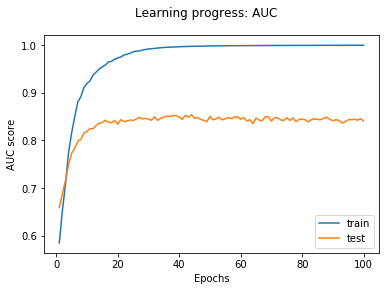

In [61]:
learning_vis_auc(train, test, item_features, 100)

In [62]:
def learning_vis_precision(train, test, item_features, k, epochs):
    
    stats = pd.DataFrame(columns = ['epochs', 'train_precision', 'test_precision', '@k' 'runtime_min'])
    model_hybrid = LightFM(no_components=100, loss='warp', random_state=2020)
    
    
    for epoch in range(1,epochs+1):
        
        start_time = time.time()
        
        model_hybrid.fit(train, 
                     item_features=item_features, 
                     epochs=epoch, 
                     num_threads=4)
        
        train_precision = precision_at_k(model_hybrid, 
                                 train,
                                 item_features=item_features, 
                                 num_threads=4, 
                                 k=k).mean()

        test_precision = precision_at_k(model_hybrid, 
                                 test,
                                 item_features=item_features, 
                                 num_threads=4, 
                                 k=k).mean()

        runtime_min = round((time.time()-start_time)/60, 6)        
        
        stats = stats.append({
            'epochs': int(epoch), 
            'train_precision': float(train_precision), 
            'test_precision': float(test_precision),
            '@k': int(k), 
            'runtime_min': float(runtime_min)},
            ignore_index=True)
        
    
    import matplotlib.pyplot as plt
    figure, axis = plt.subplots()
    figure.suptitle('Learning progress: precision @%s' %k)
    axis.plot(stats['epochs'], stats['train_precision'], label='train')
    axis.plot(stats['epochs'], stats['test_precision'], label='test')
    axis.set_xlabel('Epochs')
    axis.set_ylabel('Precision')
    axis.legend()

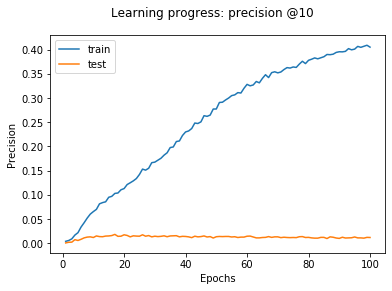

In [63]:
learning_vis_precision(train, test, item_features, k=10, epochs=100)

# Hyperparameter tuning

In [64]:
# The author of the LightFM package Maciej Kula has also developed the algorythm for hyperparameter tuning.
# Original algorythm was posted on GitHub 23 Apr 2018.
# Code is available via url https://gist.github.com/maciejkula/29aaf2db2efee5775a7f14dc387f0c0f

# For the purposes of this project the original code was modified to meet the needs.

In [65]:
# Split train set into train_train and validate subsets.

(train_train, validate) = random_train_test_split(train, 
                                                  test_percentage=0.2, 
                                                  random_state=np.random.RandomState(2020))

In [66]:
# Improving AUC metric.


def sample_hyperparameters():
    
    # Choose the hyperparameters to tune and the range of values.

    while True:
        yield {
            'no_components': np.random.randint(10, 200),
            'learning_schedule': np.random.choice(["adagrad", "adadelta"]),
            'loss': np.random.choice(['bpr', 'warp', 'warp-kos']),
            'learning_rate': np.random.exponential(0.05),
            'item_alpha': np.random.exponential(1e-10),
            'max_sampled': np.random.randint(5, 15),
            'num_epochs': np.random.randint(10, 100),
#            'random_state': 2020
        }


def random_search(train_train, validate, num_samples=10, num_threads=4):
    
    # Randomly search for various combinations of hyperparameters.


    for hyperparams in islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop('num_epochs')

        model_tuned = LightFM(**hyperparams)
        model_tuned.fit(train_train, epochs=num_epochs, num_threads=num_threads)

        ranking_score = auc_score(model_tuned, validate, train_interactions=train_train, 
                                  num_threads=num_threads).mean()

        hyperparams['num_epochs'] = num_epochs
        
        yield (ranking_score, hyperparams, model_tuned)
        # Returns: generator of (auc, hyperparameter dict, fitted model)





start_time = time.time()

if __name__ == '__main__':
    
    (ranking_score, hyperparams, model_tuned) = max(random_search(train_train, validate), 
                                                    key=lambda x: x[0])

    print('Best ranking score {} at {}'.format(ranking_score, hyperparams))
    print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Best ranking score 0.5342968106269836 at {'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.11558213963954614, 'item_alpha': 8.366479809964074e-11, 'max_sampled': 7, 'num_epochs': 74}
Calculated in:  0.22  minutes


# Tuned LightFM model training (with item features)

In [67]:
# Use the tuned model.

start_time = time.time()

model_hybrid = model_tuned

model_hybrid.fit(train, 
                 item_features=item_features, 
                 epochs=hyperparams['num_epochs'], 
                 num_threads=4)

print('Model trained in: ', round((time.time()-start_time)/60, 2), " minutes")

Model trained in:  0.1  minutes


In [68]:
# Tuned model evaluation (auc_score, precision_at_k)

In [69]:
start_time = time.time()

train_auc = auc_score(model_hybrid, 
                      train, 
                      item_features=item_features, 
                      num_threads=4).mean()

print('Train AUC score: ', train_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train AUC score:  0.9478746
Calculated in:  0.05  minutes


In [70]:
start_time = time.time()

# Train interactions fill be also passed to avoid model re-recommending items to users.
test_auc = auc_score(model_hybrid,
                     test, 
                     item_features=item_features, 
                     train_interactions = train, 
                     num_threads=4).mean()

print('Test AUC score: ', test_auc)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test AUC score:  0.80964565
Calculated in:  0.02  minutes


In [71]:
start_time = time.time()

train_precision = precision_at_k(model_hybrid, 
                                 train,
                                 item_features=item_features, 
                                 num_threads=4, 
                                 k=k).mean()

print('Train precision at k: ', train_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Train precision at k:  0.10174717
Calculated in:  0.05  minutes


In [72]:
start_time = time.time()

test_precision = precision_at_k(model_hybrid, 
                                test, 
                                item_features=item_features, 
                                train_interactions = train, 
                                num_threads=4, 
                                k=k).mean()

print('Test precision at k: ', test_precision)
print('Calculated in: ', round((time.time()-start_time)/60, 2), " minutes")

Test precision at k:  0.009777778
Calculated in:  0.02  minutes


# Recommendations

# Future work

Section 6. https://www.kdd.org/exploration_files/19-1-Article3.pdf